<a href="https://colab.research.google.com/github/yonatanrtt/sentiment-analysis/blob/main/P_f5_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><h2>Deep Learning</h2>

In this notebook, basic version of BERT+NN will be tested

In [ ]:
!pip install transformers
!pip install -q -U watermark
!pip install torch

     |████████████████████████████████| 2.6 MB 13.3 MB/s 
     |████████████████████████████████| 636 kB 58.2 MB/s 
     |████████████████████████████████| 895 kB 54.8 MB/s 
     |████████████████████████████████| 3.3 MB 52.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertModel
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from google.colab import  drive
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
drive.mount("/drive")
all_data_df = pd.read_csv("/drive/My Drive/data.csv")

Mounted at /drive


In [ ]:
all_data_df["sentiment"] = all_data_df["sentiment"].replace("positive", 1).replace("negative", 0)

<b><h3>First Step:</h3>

the first and only step of this note is using pre-trained BERT and neural network with one hidden layer only.
it is one of the most basic option using neural network and still it might return better results than the other notebooks


In [ ]:
df_train, df_test_all = train_test_split(all_data_df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test_all, test_size=0.5, random_state=42)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
MAX_LENGTH = 512
token_lens = [len(tokenizer.encode(txt, max_length=MAX_LENGTH)) for txt in all_data_df["review"]]
token_lens.sort()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<b>first of all - print the num of tokens for every review until 512 

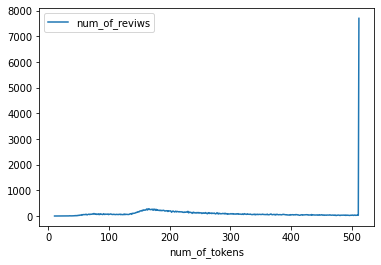

In [ ]:
tuple_token_len = [(token_len, token_lens.count(token_len)) for token_len in token_lens]
df_token_len = pd.DataFrame(tuple_token_len, columns =['num_of_tokens', 'num_of_reviws'])
df_token_len = df_token_len.sort_values("num_of_tokens")
ax = df_token_len.plot(x='num_of_tokens', y='num_of_reviws', rot=0)

<b>it can be seen that there are many reviews with at least, and probably more than 512 tokens

In [ ]:
class RunNn(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  return DataLoader(
    RunNn(
      reviews=df["review"].to_numpy(),
      targets=df["sentiment"].to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
    ),
    batch_size=batch_size,
    num_workers=4
  )

<b>in the following vector representation for the classification max-length is limited to 300 tokens due to resource limitations

In [ ]:
BATCH_SIZE = 15
MAX_LEN = 300
DROP_OUT = 0.3

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

data = next(iter(train_data_loader))

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
class Classifier(nn.Module):

  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=DROP_OUT)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
       return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
class_names = ['negative', 'positive']
model = Classifier(len(class_names))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model.to(device)

Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5029, 0.4971],
        [0.4423, 0.5577],
        [0.4183, 0.5817],
        [0.3995, 0.6005],
        [0.5092, 0.4908],
        [0.4031, 0.5969],
        [0.6669, 0.3331],
        [0.5285, 0.4715],
        [0.5712, 0.4288],
        [0.4790, 0.5210],
        [0.3844, 0.6156],
        [0.5264, 0.4736],
        [0.6111, 0.3889],
        [0.3777, 0.6223],
        [0.4977, 0.5023]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device,
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def evaluate_results(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
      
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

<b>start traning. for every epoch print the train and validation loass and accuracy

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch: {epoch + 1}')

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = evaluate_results(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch: 1
Train loss 0.276687768457669 accuracy 0.890525
Val loss 0.20105308805129485 accuracy 0.9216000000000001
Epoch: 2
Train loss 0.15871617209195446 accuracy 0.9539000000000001
Val loss 0.3194152078696549 accuracy 0.9208000000000001
Epoch: 3
Train loss 0.09449944912164304 accuracy 0.976875
Val loss 0.40399920422751817 accuracy 0.9206000000000001
Epoch: 4
Train loss 0.053931272181898665 accuracy 0.9884000000000001
Val loss 0.48395116619683326 accuracy 0.9194
Epoch: 5
Train loss 0.030561271598557798 accuracy 0.994025
Val loss 0.4855440899353383 accuracy 0.9226000000000001


<b>print on one graph the validation and training accuracy by epoch

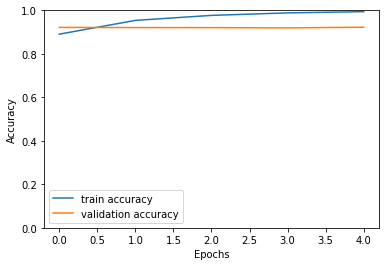

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.ylim([0, 1]);

<b>evaluate the test group. it will help to avoid overfitting

In [ ]:
test_acc, test_loss = evaluate_results(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print(f'accuracy {test_acc}')

accuracy 0.9236000000000001


<b>the next evalutaion is for compare with the results from the note  "P_f2_classifiction_supervised" on the same data

In [ ]:
test_data_loader_all = create_data_loader(df_test_all, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, test_loss = evaluate_results(
  model,
  test_data_loader_all,
  loss_fn,
  device,
  len(df_test_all)
)

print(f'accuracy {test_acc}')

accuracy 0.9231


<b>the best result from the note  "P_f2_classifiction_supervised" 89.45 wich means this note results imporved it by much

<b><h3><b>conclusion</b></h3>

1. the above test was clearly the test that gave the best results

2. results could probably be improved if the following improvements would heave been used, among  other:

a. fine-tuning for the BERT model for the task data

b. increase max-length from 300 to 512

c. use deeper network

